In [2]:
#!pip install-U yt-dlp==2023.1.6 matplotlib==3.6.0 datasets[audio] rich

# install newest transformers build to be able to pass `inputs_embeds` through generate()
!pip install --upgrade git+https://github.com/huggingface/transformers.git
!pip install librosa

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-eb4fxho3
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-eb4fxho3
  Resolved https://github.com/huggingface/transformers.git to commit 60d51ef5123d949fd8c59cd4d3254e711541d278
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 63.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 83.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 88.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 92.2 MB/s eta 0:00:00:00:01
     ━━━

In [2]:
!pip install -U torch torchaudio --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 203.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 198.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 180.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 136.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 111.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 147.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 171.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 149.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 224.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 118.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0
    Uninstalling torch-1.13.0:
      S

In [5]:
!pip install evaluate

In [45]:
from musiccaps import load_musiccaps

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split, Subset

from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer

from rich import print as printr
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

import itertools
import math
import json
import random
from collections import defaultdict
from pathlib import Path
import evaluate
import itertools

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import sys
sys.path.insert(1, './sota-music-tagging-models/training')
import model as sota_model

# Load musiccaps

In [134]:
ds = load_musiccaps(
    "./music_data",
    sampling_rate=16000,
    limit=None,
    num_proc=8,
    writer_batch_size=1000,
    return_without_audio=True,
)

music_files = {f.stem: f for f in Path('./music_npys/').iterdir()}

Using custom data configuration google--MusicCaps-bedc2a0fd7888f2f
Reusing dataset csv (/root/.cache/huggingface/datasets/google___csv/google--MusicCaps-bedc2a0fd7888f2f/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


In [135]:
class CaptionMusicDataset(Dataset):
    """Returns a torch Dataset of paired captions and music files"""

    def __init__(self, muscaps_ds, music_files, chat_aug=False, aug_captions=None):
        include_ytids = set(muscaps_ds['ytid']) & set(music_files.keys())
        include_inds = [i for i, ytid in enumerate(muscaps_ds['ytid']) if ytid in include_ytids]
        ds = muscaps_ds.select(include_inds)
        assert len(ds) == len(music_files)

        ytids_sorted = ds.sort("ytid")["ytid"]
        self.captions = ds.sort("ytid")["caption"]
        self.sorted_music_files = [music_files[ytid] for ytid in ytids_sorted]
        self.chat_aug = chat_aug
        if chat_aug:
            self.aug_captions = [aug_captions[ytid] for ytid in ytids_sorted]
            self.n_aug_captions = len(self.aug_captions[0])

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        music = np.load(self.sorted_music_files[idx], allow_pickle=True)
        caption = self.captions[idx]
        if self.chat_aug:
            if torch.rand(1).item() < 1 - 1./self.n_aug_captions: 
                caption = np.random.choice(self.aug_captions[idx])
                
        music = np.stack([music[:80000], music[-80000:]])

        return caption, music

In [136]:
use_chat_aug = False

with open('chataug.json', 'r') as fp:
    chataug_captions = json.load(fp)
    
with open('musiccaps_split.json', 'r') as fp:
    musiccaps_split = json.load(fp)

train_ytids, valid_ytids, test_ytids = musiccaps_split['train'], musiccaps_split['valid'], musiccaps_split['test']

train_ds = ds.filter(lambda x: x['ytid'] in train_ytids)
valid_ds = ds.filter(lambda x: x['ytid'] in valid_ytids)
test_ds = ds.filter(lambda x: x['ytid'] in test_ytids)

train_music_files = {ytid: e for ytid, e in music_files.items() if ytid in train_ytids}
valid_music_files = {ytid: e for ytid, e in music_files.items() if ytid in valid_ytids}
test_music_files = {ytid: e for ytid, e in music_files.items() if ytid in test_ytids}

training_data = CaptionMusicDataset(muscaps_ds=train_ds, music_files=train_music_files, 
                                    chat_aug=use_chat_aug, aug_captions=chataug_captions)
valid_data = CaptionMusicDataset(muscaps_ds=valid_ds, music_files=valid_music_files)
test_data = CaptionMusicDataset(muscaps_ds=test_ds, music_files=test_music_files) 

Loading cached processed dataset at /root/.cache/huggingface/datasets/google___csv/google--MusicCaps-bedc2a0fd7888f2f/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-65e36bf881a776b6.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/google___csv/google--MusicCaps-bedc2a0fd7888f2f/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-b43b658bbefe199e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/google___csv/google--MusicCaps-bedc2a0fd7888f2f/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-f4182c0212b9d53a.arrow


In [137]:
len(training_data), len(valid_data), len(test_data)

(236, 25, 29)

# Training

In [138]:
class ResidualLinear(nn.Module):
    
    def __init__(self, dim):
        super().__init__()
        self.fc = nn.Linear(dim, dim)
        
    def forward(self, x):
        return x + self.fc(torch.nn.functional.relu(x))

class B2T(nn.Module):
    def __init__(self):
        super(B2T, self).__init__()
        self.hcnn = sota_model.HarmonicCNN().to(device)
        state_dict = torch.load(f'sota-music-tagging-models/models/jamendo/hcnn/best_model.pth',
                        map_location=device)
        self.hcnn.load_state_dict(state_dict)
        self.fc_net = nn.Sequential(
            nn.Linear(50, 768),
            ResidualLinear(768),
            nn.Dropout(0.4),
            ResidualLinear(768),
        )
        
    def forward(self, audio_array):
        audio_features = (self.hcnn(audio_array[:, 0, :])+self.hcnn(audio_array[:, 1, :]))/2
        audio_embedding = self.fc_net(audio_features)
    
        return audio_embedding

In [139]:
def tokenize(captions_batch):
    input_ids = tokenizer(captions_batch)["input_ids"]

    # wrap in eos and add placeholder for music embedding/mask
    input_ids = [torch.tensor([placeholder_id] + x + [eos_id]) for x in input_ids]
    # pad with -100, this index is masked in the cross-entropy loss
    input_ids_target = torch.nn.utils.rnn.pad_sequence(
        input_ids, batch_first=True, padding_value=mask_id
    ).to(device)

    # index -100 isn't valid as model input however, since the token embedding lookup fails,
    # so we need a second version as model input, with -100 replaced with another token (shouldn't matter which)
    input_ids = input_ids_target.clone()
    input_ids[input_ids == mask_id] = eos_id

    return input_ids, input_ids_target


def transform_input_ids(music_array, input_ids, input_ids_target):
    music_emb_ind = 0  # 1 if using <bos>, otherwise 0
    assert (input_ids[:, music_emb_ind] == placeholder_id).all()
    assert (input_ids_target[:, music_emb_ind] == placeholder_id).all()

    input_ids_target[:, music_emb_ind] = eos_id  # mask_id
    input_ids[:, music_emb_ind] = eos_id  # temp placeholder to make the embedding lookup work
    inputs_embeds = model.transformer.wte(input_ids)
    inputs_embeds[:, music_emb_ind] = b2t(music_array.cuda())  # insert music embedding

    return inputs_embeds, input_ids_target


def strip_eos(pred):
    """ 
    remove eos tokens from predicted captions 
    discards everything after the first <eos> that isn't the very first token
    (the hf can only skip eos but not stop at eos) 
    """
    pred = [p.removeprefix("<|endoftext|>") for p in pred]
    pred = [p[: p.find("<|endoftext|>")] if "<|endoftext|>" in p else p for p in pred]
    return pred


def eval(caption_batch, audio_batch, rm_eos=False, **kwargs):
    model.eval()
    b2t.eval()
    input_ids, input_ids_target = tokenize(caption_batch)
    inputs_embeds, _ = transform_input_ids(audio_batch, input_ids, input_ids_target)

    # only include <bos> (optional) and music_embedding, don't include true caption
    inputs_embeds = inputs_embeds[:, :1]
    output_ids = model.generate(inputs_embeds=inputs_embeds, **kwargs)
    pred = tokenizer.batch_decode(output_ids, skip_special_tokens=False)
    pred = [p.replace("\n", "").strip() for p in pred]
    return strip_eos(pred) if rm_eos else pred

In [140]:
def update_step(inputs_embeds, input_ids_target, apply_grad):
    model.train()
    b2t.train()
    loss = model.forward(inputs_embeds=inputs_embeds, labels=input_ids_target).loss
    loss.backward()
    
    if apply_grad:
        opt.step()
        opt.zero_grad()
    
    return loss.item()

def eval_step(string_info=""):
    
    caption_batch, embedding_batch = next(iter(eval_train_dataloader))
    pred = eval(caption_batch, embedding_batch, **generation_params)
    printr('[green bold]TRAIN TRUE: ' + caption_batch[0])
    printr('[yellow]TRAIN PRED: ' + pred[0])
    wlog('TRAIN TRUE: ' + caption_batch[0])
    wlog('TRAIN PRED: ' + pred[0])
    caption_batch, embedding_batch = next(iter(eval_valid_dataloader))
    pred = eval(caption_batch, embedding_batch, **generation_params)
    printr('[green bold]TEST TRUE: ' + caption_batch[0])
    printr('[yellow]TEST PRED: ' + pred[0])
    wlog('TEST TRUE: ' + caption_batch[0])
    wlog('TEST PRED: ' + pred[0])
    print()
    
def metrics_step(n=100, shuffles=10):
    
    lq = 0
    
    print(f"Computing metrics for n={n}")
    wlog(f"Computing metrics for n={n}")
    
    shuffled_meteor_valid, shuffled_bleu_valid = 0., 0.
    train_captions, train_preds = [], []
    valid_captions, valid_preds = [], []

    for i in tqdm(range(n)):

        caption_batch, embedding_batch = next(iter(eval_train_dataloader))
        pred = eval(caption_batch, embedding_batch, **generation_params)
        train_captions.append(caption_batch[0])
        train_preds.append(pred[0])

        caption_batch, embedding_batch = next(iter(eval_valid_dataloader))
        pred = eval(caption_batch, embedding_batch, **generation_params)
        valid_captions.append(caption_batch[0])
        valid_preds.append(pred[0])
        if "The low quality recording" in pred[0]:
            lq += 1

    meteor_train = meteor.compute(predictions=train_preds, references=train_captions)['meteor']
    bleu_train = google_bleu.compute(predictions=train_preds, references=train_captions)['google_bleu']

    meteor_valid = meteor.compute(predictions=valid_preds, references=valid_captions)['meteor']
    bleu_valid = google_bleu.compute(predictions=valid_preds, references=valid_captions)['google_bleu']
    
    for j in range(shuffles):
        shuffled_captions = sorted(valid_captions, key=lambda k: random.random())
        shuffled_meteor_valid += (1./(shuffles))*meteor.compute(predictions=valid_preds, references=shuffled_captions)['meteor']
        shuffled_bleu_valid += (1./(shuffles))*google_bleu.compute(predictions=valid_preds, references=shuffled_captions)['google_bleu']

    spec_meteor = meteor_valid - shuffled_meteor_valid
    spec_bleu = bleu_valid - shuffled_bleu_valid
        
    print(f"Train meteor: {meteor_train:.4f}, Train bleu: {bleu_train:.4f}")
    wlog(f"Train meteor: {meteor_train:.4f}, Train bleu: {bleu_train:.4f}")
    print(f"Valid meteor: {meteor_valid:.4f}, Valid bleu: {bleu_valid:.4f}")
    wlog(f"Valid meteor: {meteor_valid:.4f}, Valid bleu: {bleu_valid:.4f}")
    print(f"Valid spec-meteor: {spec_meteor:.4f}, Valid spec-bleu: {spec_bleu:.4f}")
    wlog(f"Valid spec-meteor: {spec_meteor:.4f}, Valid spec-bleu: {spec_bleu:.4f}")
    print(f"Low quality recording count: {lq}")
    wlog(f"Low quality recording count: {lq}")
    
    return {'meteor_train': meteor_train,
            'meteor_valid': meteor_valid,
            'bleu_train': bleu_train,
            'bleu_valid': bleu_valid,
            'spec_meteor': spec_meteor,
            'spec_bleu': spec_bleu} 

m_styles = {"meteor_train": ("tab:orange", "solid"),
    "meteor_valid": ("tab:orange", "dashed"),
    "bleu_train": ("tab:blue", "solid"),
    "bleu_valid": ("tab:blue", "dashed"),
    "spec_bleu": ("tab:blue", "dashdot"),
    "spec_meteor": ("tab:orange", "dashdot")
}
    

In [141]:
def metrics_step(n=100, shuffles=10):
    
    lq = 0
    
    print(f"Computing metrics for n={n}")
    wlog(f"Computing metrics for n={n}")
    
    shuffled_meteor_valid, shuffled_bleu_valid = 0., 0.
    train_captions, train_preds = [], []
    valid_captions, valid_preds = [], []

    for i in tqdm(range(n)):

        caption_batch, embedding_batch = next(iter(eval_train_dataloader))
        pred = eval(caption_batch, embedding_batch, **generation_params)
        train_captions.append(caption_batch[0])
        train_preds.append(pred[0])

        caption_batch, embedding_batch = next(iter(eval_valid_dataloader))
        pred = eval(caption_batch, embedding_batch, **generation_params)
        valid_captions.append(caption_batch[0])
        valid_preds.append(pred[0])
        if "The low quality recording" in pred[0]:
            lq += 1

    meteor_train = meteor.compute(predictions=train_preds, references=train_captions)['meteor']
    bleu_train = google_bleu.compute(predictions=train_preds, references=train_captions)['google_bleu']

    meteor_valid = meteor.compute(predictions=valid_preds, references=valid_captions)['meteor']
    bleu_valid = google_bleu.compute(predictions=valid_preds, references=valid_captions)['google_bleu']
    
    for j in range(shuffles):
        shuffled_captions = sorted(valid_captions, key=lambda k: random.random())
        shuffled_meteor_valid += (1./(shuffles))*meteor.compute(predictions=valid_preds, references=shuffled_captions)['meteor']
        shuffled_bleu_valid += (1./(shuffles))*google_bleu.compute(predictions=valid_preds, references=shuffled_captions)['google_bleu']

    spec_meteor = meteor_valid - shuffled_meteor_valid
    spec_bleu = bleu_valid - shuffled_bleu_valid
        
    print(f"Train meteor: {meteor_train:.4f}, Train bleu: {bleu_train:.4f}")
    wlog(f"Train meteor: {meteor_train:.4f}, Train bleu: {bleu_train:.4f}")
    print(f"Valid meteor: {meteor_valid:.4f}, Valid bleu: {bleu_valid:.4f}")
    wlog(f"Valid meteor: {meteor_valid:.4f}, Valid bleu: {bleu_valid:.4f}")
    print(f"Valid spec-meteor: {spec_meteor:.4f}, Valid spec-bleu: {spec_bleu:.4f}")
    wlog(f"Valid spec-meteor: {spec_meteor:.4f}, Valid spec-bleu: {spec_bleu:.4f}")
    print(f"Low quality recording count: {lq}")
    wlog(f"Low quality recording count: {lq}")
    
    return {'meteor_train': meteor_train,
            'meteor_valid': meteor_valid,
            'bleu_train': bleu_train,
            'bleu_valid': bleu_valid,
            'spec_meteor': spec_meteor,
            'spec_bleu': spec_bleu} 

m_styles = {"meteor_train": ("tab:orange", "solid"),
    "meteor_valid": ("tab:orange", "dashed"),
    "bleu_train": ("tab:blue", "solid"),
    "bleu_valid": ("tab:blue", "dashed"),
    "spec_bleu": ("tab:blue", "dashdot"),
    "spec_meteor": ("tab:orange", "dashdot")
}
    

In [142]:
model_name = 'gpt2' # gpt2, gpt2-medium, gpt2-large, gpt2-xl
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
model.config.is_decoder = True # not sure if necessary

mask_id = -100 # don't change, this is fixed in torch cross-entropy loss!
eos_id = tokenizer.eos_token_id
placeholder_id = -200
b2t = B2T().cuda()
b2t_lr = 1e-4
gpt2_finetune_lr = 5e-5

opt = torch.optim.AdamW([
    # b2t needs to be the first parameter group
    {'params': b2t.parameters(), 'lr': b2t_lr},
    
    # disable AdamW weight decay for gpt2 layer finetuning
    {'params': model.transformer.h[1].parameters(), 'lr': gpt2_finetune_lr, 'weight_decay': 0},
    {'params': model.transformer.h[2].parameters(), 'lr': gpt2_finetune_lr, 'weight_decay': 0}
])

batch_size = 16
num_epochs = 500
epoch = 0
gradient_acc_fact = 4
gpt2_finetune_start_epoch = 0

generation_params = dict(
    max_new_tokens=64,
    num_beams=8,
    do_sample=True,
    temperature=1.0,
    bos_token_id=eos_id,
    eos_token_id=eos_id,
    pad_token_id=mask_id,
    early_stopping=True,
    rm_eos=True,
)

losses = []

train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
eval_train_dataloader = DataLoader(training_data, 1, shuffle=True)
eval_valid_dataloader = DataLoader(valid_data, 1, shuffle=True)

meteor = evaluate.load('meteor')
google_bleu = evaluate.load("google_bleu")
metrics = {'step': [], 'bleu_train': [], 'bleu_valid': [], 'meteor_train': [], 'meteor_valid': [],
          'spec_bleu': [], 'spec_meteor':[]}

checkpoint_dir = Path('checkpoints')
checkpoint_dir.mkdir(exist_ok=True)

load_pretrain = False
keep_training = False

pretrain_model =  "saved-models/best-notag-chataug.pt"
if load_pretrain:
    data_dict = torch.load(pretrain_model)
    model.load_state_dict(data_dict['model'])
    b2t.load_state_dict(data_dict['b2t'])
    
model_name_info = "small" if model_name == 'gpt2' else model_name
pretraining_info = "yes" if load_pretrain and not keep_training else "no"
chat_aug_info = "_chataug" if use_chat_aug else ""
string_info = f"{pretraining_info}_{gpt2_finetune_lr}_{gpt2_finetune_start_epoch}_{b2t_lr}{chat_aug_info}_trainall"

def wlog(s):
    f = open(f"outputs/logs_{string_info}.txt",'a')
    f.write(s+"\n")
    f.close()
    
if keep_training:
    with open(f'outputs/train_metrics_{string_info}.npy', 'rb') as f:
        train_metrics = np.load(f, allow_pickle=True).item()
    
    losses = list(train_metrics['loss'])
    metrics = {k: list(v) for k,v in train_metrics.items()}

string_info

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


'no_5e-05_0_0.0001_trainall'

  0%|          | 0/500 [00:00<?, ?it/s]

Started finetuning b2t


  0%|          | 0/15 [00:00<?, ?it/s]

TRAIN TRUE: A male vocalist sings this catchy Hip-Hop. The tempo is medium with an acoustic guitar riff, boomy bass
drops, punchy drumming, digital beats and synthesiser arrangement with enthusiastic vocal backup. The song is 
youthful, buoyant, punchy, groovy, pulsating with a dance groove. This song is Contemporary Hip-Hop.

TRAIN PRED: ."I'm going to tell you what it is," he said. "I'm going to tell you what it is. I'm going to tell you 
what it is. I'm going to tell you what it is. I'm going to tell you what it is. I'm going to tell you

TEST TRUE: The low quality recording features an uptempo didgeridoo melody. It sounds reverberant, as it was 
probably played in a medium size room, and the recording is a bit noisy.

TEST PRED: ."I don't know what's going on, but I don't know what's going on," he said. "I don't know what's going 
on. I don't know what's going on. I don't know what's going on. I don't know what's going on."

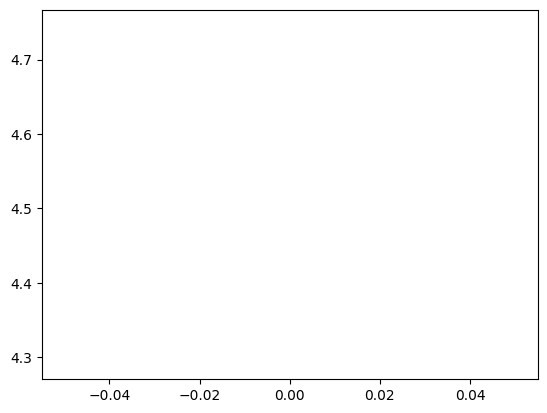

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

TRAIN TRUE: The low quality recording features a reverberant, electric guitar solo melody. The recording is noisy 
and in mono.

TRAIN PRED: The song is a mix of classical music and electronic music. The song is a mix of classical music and 
electronic music. The song is a mix of classical music and electronic music. The song is a mix of classical music 
and electronic music. The song is a mix of classical music and electronic music. The song is a

TEST TRUE: This music is an electric guitar instrumental Rock. The tempo is medium with an electric guitar lead. 
The music is loud and boomy with an intense riff. The audio quality is inferior so the sound is muffled and muddy. 
The music however is energetic, youthful, spirited and enthusiastic.

TEST PRED: Topics: Audience, SoundboardGrateful Dead 1,902 1.8K 1985-09-03: New Orleans, LA by Grateful Dead etree 
eye 1,902 favorite 0 comment 0Set 1Grateful Dead 1,902 1.8

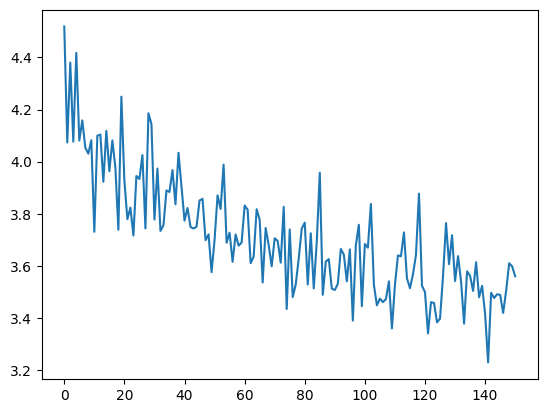

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

TRAIN TRUE: The low quality recording features an acoustic rhythm guitar playing over a pop song played on playback
in the background. It sounds joyful and happy, while the recording is in mono and noisy.

TRAIN PRED: The low quality recording features an acoustic guitar playing an acoustic guitar melody. The sound 
quality is good. The sound quality is good. The sound quality is good.

TEST TRUE: The music features a few girl voices singing a melody in harmony. An acoustic guitar accompanies the 
singers with strummed chords. The overall atmosphere is calming and moving at the same time.

TEST PRED: The instrumental is a combination of piano and drumming. The tempo of this instrumental is fast and 
rhythmic. The rhythm of this instrumental is fast and rhythmic. The tempo of this instrumental is fast and 
rhythmic. The instrumental is fast and rhythmic.

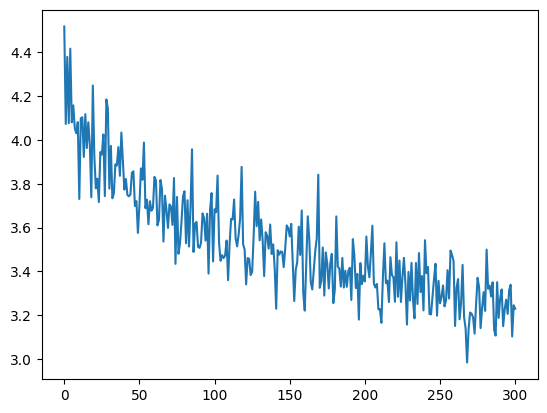

Computing metrics for n=100


  0%|          | 0/100 [00:00<?, ?it/s]

Train meteor: 0.1590, Train bleu: 0.0711
Valid meteor: 0.1790, Valid bleu: 0.0647
Valid spec-meteor: 0.0077, Valid spec-bleu: 0.0037
Low quality recording count: 22


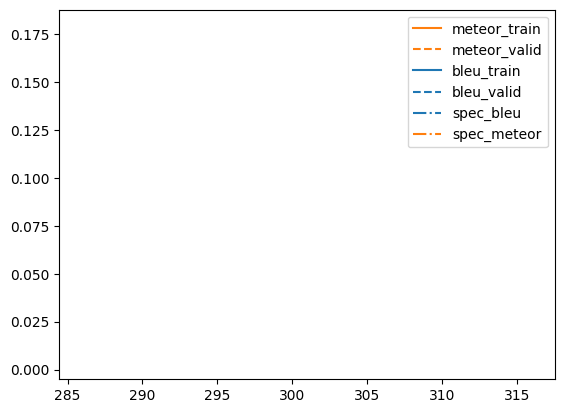

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

TRAIN TRUE: The low quality recording features an acoustic rhythm guitar playing over a pop song played on playback
in the background. It sounds joyful and happy, while the recording is in mono and noisy.

TRAIN PRED: The low quality recording features a live performance of a song. The song is upbeat and upbeat. The 
audio quality is poor.

TEST TRUE: A trombone is ending a melody together with a tuba and other brass instruments before going into the 
next part that sounds fast paced and uplifting. This song may be playing at a live performance.

TEST PRED: The low quality recording features an acoustic guitar playing a melody. The sound quality of this 
recording is poor. The audio quality of this recording is poor.

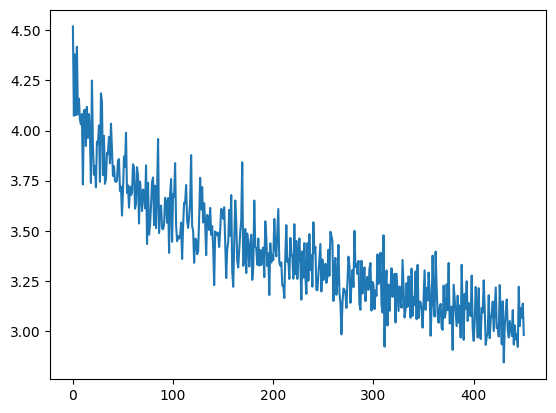

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

TRAIN TRUE: A male vocalist sings this catchy Hip-Hop. The tempo is medium with an acoustic guitar riff, boomy bass
drops, punchy drumming, digital beats and synthesiser arrangement with enthusiastic vocal backup. The song is 
youthful, buoyant, punchy, groovy, pulsating with a dance groove. This song is Contemporary Hip-Hop.

TRAIN PRED: The low quality recording features an instrumental. It sounds upbeat, upbeat, upbeat, upbeat, upbeat, 
upbeat, upbeat, upbeat, upbeat, upbeat, upbeat, upbeat, upbeat, upbeat, upbeat, upbeat, upbeat, upbeat, upbeat, 
upbeat, upbeat, upbeat, upbeat, upbeat, upbeat, upbeat, upbeat,

TEST TRUE: Someone is playing a e-guitar solo over another e-guitar providing jazz chords along with acoustic drums
playing a jazzy groove with little licks and a steady straight groove in the ride that is panned to the right side 
of the speakers. An upright bass in playing a walking bassline. This song may be playing at a jazz bar.

TEST PRED: The low quality recording features a live performance of a song by a male vocalist. The recording is 
noisy and the audio quality is poor. The audio quality is poor.

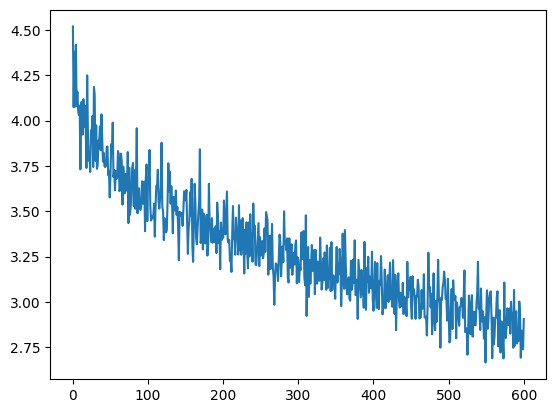

Computing metrics for n=100


  0%|          | 0/100 [00:00<?, ?it/s]

Train meteor: 0.1677, Train bleu: 0.0796
Valid meteor: 0.2132, Valid bleu: 0.0941
Valid spec-meteor: 0.0063, Valid spec-bleu: -0.0022
Low quality recording count: 97


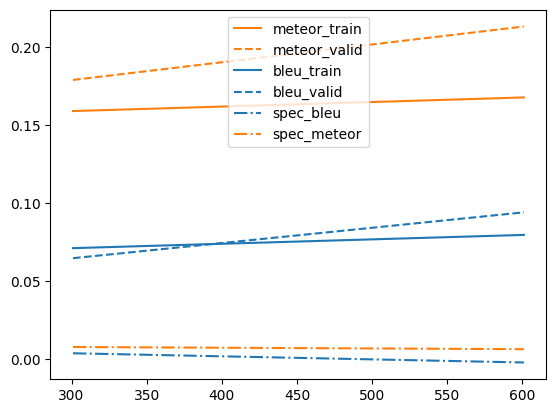

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

TRAIN TRUE: The music features a synth sound playing a repeating melody. An electric piano accompanies the melody 
with chords. In the second half of the music except the drums and bass guitar kick in. Listening to this music I 
get lounge vibes.

TRAIN PRED: The low quality recording features an acoustic guitar playing a melody. The recording is noisy and the 
audio quality is poor.

TEST TRUE: The low quality recording features a groovy tabla percussion playing. The recording is noisy and in 
mono.

TEST PRED: The low quality recording features a folk song that consists of a piano playing a melody. The recording 
is noisy and noisy. The audio quality is poor.

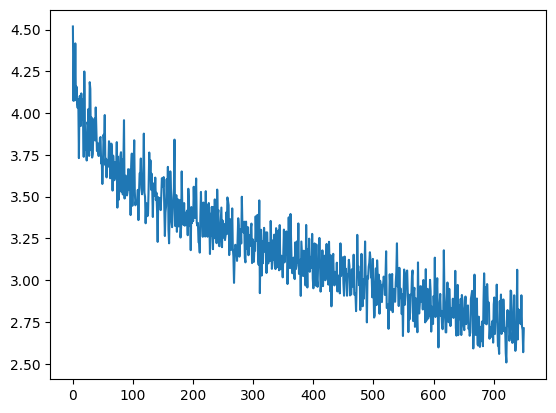

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

TRAIN TRUE: This music is instrumental. The tempo is slow with a euphonious harp melody with no accompaniment. The 
music is soft, mellow, ethereal, melancholic, nostalgic, pensive, soft and ambient. This music is a Western 
Classical.

TRAIN PRED: The low quality recording features a live performance of a folk song. The recording is noisy and the 
recording is noisy.

TEST TRUE: This pop rock song features a male voice. This is accompanied by percussion playing a simple beat in 
common time. A lead guitar with heavy reverb plays a fill in between lines. An acoustic guitar strums chords in the
background. A bass plays the root notes of the chords. The mood of this song is romantic. This song is played at a 
slow tempo. This song can be played in a retro romantic movie.

TEST PRED: The low quality recording features a live performance of a classical music piece. It sounds passionate 
and passionate. The recording is noisy and noisy.

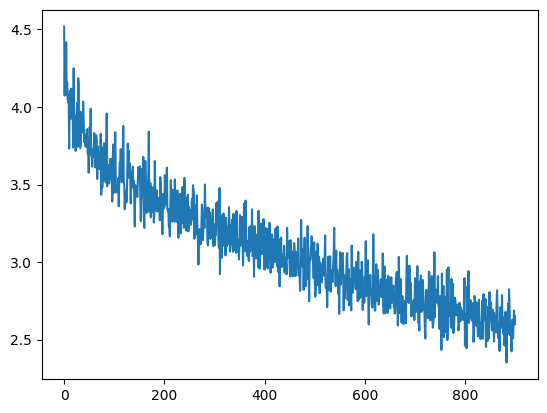

Computing metrics for n=100


  0%|          | 0/100 [00:00<?, ?it/s]

Train meteor: 0.1662, Train bleu: 0.0811
Valid meteor: 0.2049, Valid bleu: 0.1005
Valid spec-meteor: 0.0003, Valid spec-bleu: 0.0001
Low quality recording count: 97


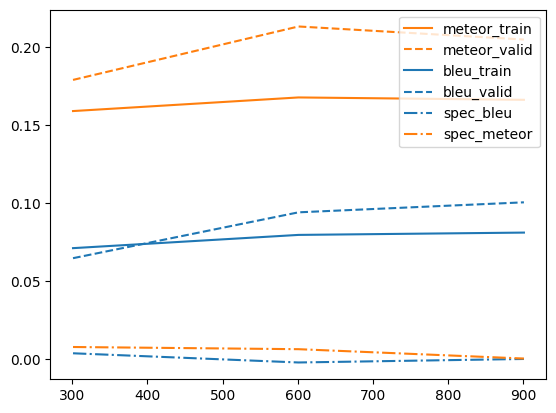

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

TRAIN TRUE: A synthesizer holds a note with increasingly wide vibrato then joins the string bass ensemble in 
playing a lurching, creeping melody. Sounds like music from a spooky video game. Fearful male muttering can also be
heard.

TRAIN PRED: The low quality recording features a live performance of a folk song. The recording is noisy and the 
recording is noisy.

TEST TRUE: The low quality recording features a beatboxing over harmonica solo melody. It sounds groovy and the 
recording is groovy and in mono.

TEST PRED: The low quality recording features a live performance of a folk song. The recording is noisy and the 
recording is noisy.

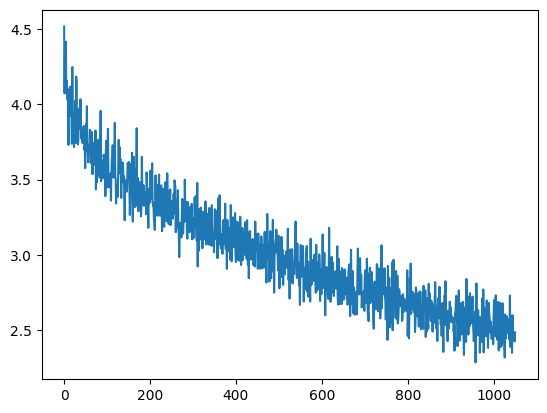

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

TRAIN TRUE: The low quality recording features a tutorial that consists of a french horn melody played in-between 
flat male vocal talking. The recording is noisy, mono and quiet.

TRAIN PRED: The low quality recording features a live performance of a folk song. The recording is noisy and the 
recording is noisy.

TEST TRUE: The low quality recording features a cover of a rock song and it consists of a funky acoustic bass 
guitar solo melody played aggressively. It sounds groovy and the recording is noisy and in mono.

TEST PRED: The low quality recording features a live performance of a folk song. The recording is noisy and noisy.

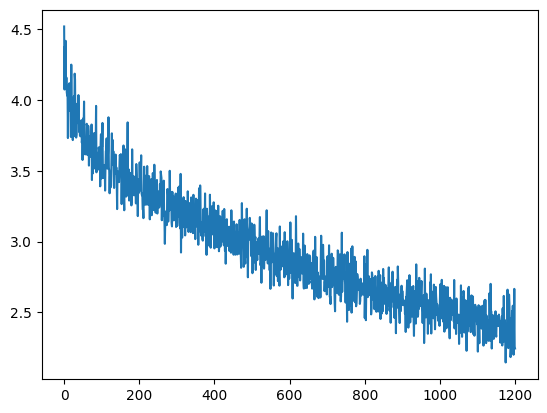

Computing metrics for n=100


  0%|          | 0/100 [00:00<?, ?it/s]

Train meteor: 0.1631, Train bleu: 0.0797
Valid meteor: 0.2022, Valid bleu: 0.0904
Valid spec-meteor: -0.0059, Valid spec-bleu: -0.0027
Low quality recording count: 100


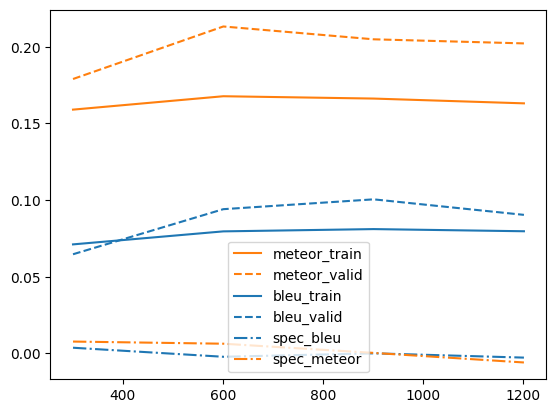

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

TRAIN TRUE: This audio is of a low quality recording. It is a hip-hop song featuring a male voice singing the main 
melody. This is accompanied by a female voice singing vocals in an angelic voice in the background. Programmed 
percussion plays a simple beat with the hi-hat being struck at every count. The bass plays the root notes of the 
chords. The bass notes are allowed to ring. This song has a slow tempo. This song can be played in a club.

TRAIN PRED: The song is an instrumental. The song is medium tempo with an electric guitar accompaniment. The song 
is upbeat, uplifting, uplifting, uplifting and uplifting. The song is uplifting, uplifting, uplifting, uplifting, 
uplifting, uplifting, uplifting, uplifting, uplifting

TEST TRUE: This song contains bells playing a melody sounding like a lullaby. In the background you can hear people
talking. This song may be playing near a church during holidays.

TEST PRED: The low quality recording features a live performance of a folk song. The recording is noisy and the 
recording is noisy.

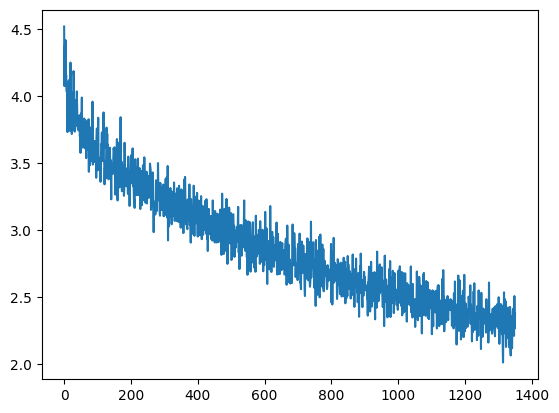

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
for epoch in tqdm(range(epoch, num_epochs)):
    wlog(f"\nEpoch {epoch}")

    torch.save({
        "model": model.state_dict(), 
        "b2t": b2t.state_dict(), 
        "opt": opt
    }, checkpoint_dir / f"chkp_{string_info}.pt")
    #}, checkpoint_dir / f"chkp_{epoch}.pt")
    
    if epoch>500 and epoch % 100 == 0:
        print("Checkpoint saved")
        wlog("Checkpoint saved")
        torch.save({
            "model": model.state_dict(), 
            "b2t": b2t.state_dict(), 
            "opt": opt
        }, checkpoint_dir / f"chkp_{string_info}_e{epoch}.pt")

    if epoch == gpt2_finetune_start_epoch:
        print("Started finetuning b2t")
        wlog("Started finetuning b2t")
        torch.save({
        "model": model.state_dict(), 
        "b2t": b2t.state_dict(), 
        "opt": opt
        }, checkpoint_dir / f"chkp_{string_info}.pt")
        opt.param_groups[0]["lr"] = b2t_lr
        for pg in opt.param_groups[1:]:
            pg["lr"] = gpt2_finetune_lr

    for step, (caption_batch, embedding_batch) in enumerate(tqdm(train_dataloader)):
        # tokenize and prepare inputs for forward
        input_ids, input_ids_target = tokenize(list(caption_batch))
        inputs_embeds, input_ids_target = transform_input_ids(
            embedding_batch, input_ids, input_ids_target
        )

        apply_grad_cond = step % gradient_acc_fact == 0
        losses.append(
            update_step(inputs_embeds, input_ids_target, apply_grad=apply_grad_cond)
        )

        if epoch % 10 == 0 and step % 500 == 0:
            wlog(f"Loss {np.mean(losses[-500:])}\n")
            eval_step(string_info=string_info)
                
            plt.plot(losses, label='train_loss')
            plt.savefig(f"plots/plot_loss_{string_info}.png")
            plt.show()
            plt.clf()
            
            if epoch % 20 == 0 and epoch>0:
                
                metrics_results = metrics_step(n=100)
                metrics['step'].append(len(losses))
                for m in ['meteor_train', 'meteor_valid', 'bleu_train', 'bleu_valid', 'spec_bleu', 'spec_meteor']:
                    metrics[m].append(metrics_results[m])
                    plt.plot(metrics['step'], metrics[m], label=m, linestyle=m_styles[m][1], color=m_styles[m][0])
                plt.legend()
                plt.savefig(f"plots/plot_metrics_{string_info}.png")
                plt.show()

                with open(f'outputs/train_metrics_{string_info}.npy', 'wb') as f:
                    metrics_to_save = {k: np.array(a) for k, a in metrics.items()}
                    metrics_to_save['loss'] = np.array(losses)
                    np.save(f, metrics_to_save)

# Generate eval captions

In [ ]:
import evaluate

meteor = evaluate.load('meteor')
google_bleu = evaluate.load('google_bleu')

In [ ]:
for ep in tqdm(["260", "270", "275", "280"]):
    
    eval_true_captions = []
    eval_pred_captions = []
    # load epoch checkpoint
    model_path = f"checkpoints/chkp_no_0.0001_0_0.0001_e{ep}.pt"
    data_dict = torch.load(model_path)
    model.load_state_dict(data_dict['model'])
    b2t.load_state_dict(data_dict['b2t'])

    eval_test_dataloader = DataLoader(test_data, 1, shuffle=False)

    # generate a bunch of captions with this checkpoint
    # for some reason hf generate() breaks atm when using batched captions, idk why
    for i, (caption_batch, embedding_batch) in enumerate(tqdm(eval_test_dataloader)):
        pred = eval(list(caption_batch), embedding_batch, **generation_params)
        eval_true_captions.append(caption_batch[0])
        eval_pred_captions.append(pred[0])
        if i >= 1000:
            break

    gleu_score = google_bleu.compute(predictions=eval_pred_captions, references=eval_true_captions)['google_bleu']
    meteor_score = meteor.compute(predictions=eval_pred_captions, references=eval_true_captions)['meteor']
    print(ep, gleu_score, meteor_score)
    
    eval_true_shuffled = sorted(eval_true_captions, key=lambda k: random.random())

    shuffled_gleu_score = google_bleu.compute(predictions=eval_pred_captions, references=eval_true_shuffled)['google_bleu']
    shuffled_meteor_score = meteor.compute(predictions=eval_pred_captions, references=eval_true_shuffled)['meteor']
    print(ep, gleu_score-shuffled_gleu_score, meteor_score-shuffled_meteor_score)

In [ ]:
ls checkpoints

In [ ]:
eval_true_captions = []
eval_pred_captions = []

model_path = "saved-models/best-notag-chataug.pt"
data_dict = torch.load(model_path)
model.load_state_dict(data_dict['model'])
b2t.load_state_dict(data_dict['b2t'])

eval_test_dataloader = DataLoader(test_data, 1, shuffle=False)


generation_params = dict(
    max_new_tokens=200,
    num_beams=8,
    do_sample=True,
    temperature=1.05,
    bos_token_id=eos_id,
    eos_token_id=eos_id,
    pad_token_id=mask_id,
    early_stopping=True,
    rm_eos=True,
)

for i, (caption_batch, embedding_batch) in tqdm(enumerate(eval_test_dataloader)):
    pred = eval(list(caption_batch), embedding_batch, **generation_params)
    eval_true_captions.append(caption_batch[0])
    eval_pred_captions.append(pred[0])
    
json.dump(dict(
    eval_true_captions=eval_true_captions,
    eval_pred_captions=eval_pred_captions,
    tracks_ids = sorted(test_ytids)
), open('outputs/preds_gpt2_notag_chataug-tweaked.json', 'w'))

In [ ]:
eval_true_captions = [re.sub(r'[^\w\s]','',x).lower() for x in eval_true_captions]
eval_pred_captions = [re.sub(r'[^\w\s]','',x).lower() for x in eval_pred_captions]

In [ ]:
gleu_score = google_bleu.compute(predictions=eval_pred_captions, references=eval_true_captions)['google_bleu']
meteor_score = meteor.compute(predictions=eval_pred_captions, references=eval_true_captions)['meteor']
print(gleu_score, meteor_score)

In [ ]:
eval_true_captions = []
eval_pred_captions = []

model_path = "saved-models/best-notag-noaug.pt"
data_dict = torch.load(model_path)
model.load_state_dict(data_dict['model'])
b2t.load_state_dict(data_dict['b2t'])

eval_test_dataloader = DataLoader(test_data, 1, shuffle=False)

for i, (caption_batch, embedding_batch) in tqdm(enumerate(eval_test_dataloader)):
    pred = eval(list(caption_batch), embedding_batch, **generation_params)
    eval_true_captions.append(caption_batch[0])
    eval_pred_captions.append(pred[0])

In [ ]:
json.dump(dict(
    eval_true_captions=eval_true_captions,
    eval_pred_captions=eval_pred_captions,
    tracks_ids = ["-"+str(x) for x in sorted(test_ytids)]
), open('outputs/preds_gpt2_notag_noaug-tweaked.json', 'w'))

In [ ]:
gleu_score = google_bleu.compute(predictions=eval_pred_captions, references=eval_true_captions)['google_bleu']
meteor_score = meteor.compute(predictions=eval_pred_captions, references=eval_true_captions)['meteor']

gleu_score, meteor_score

In [ ]:
gleu_score, meteor_score